## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Function to vonvert the image to grey scale and to use cv2.calibrateCamera and cv2.undistort()
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    shape = gray.shape[::-1]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

Total of calibration images:  20


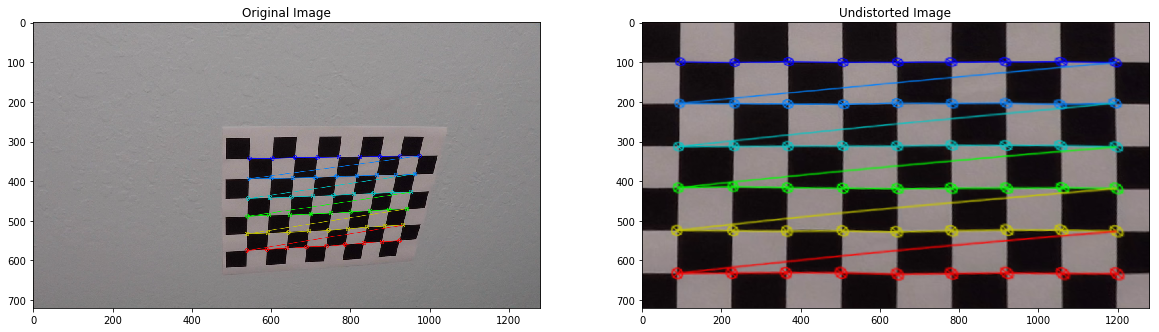

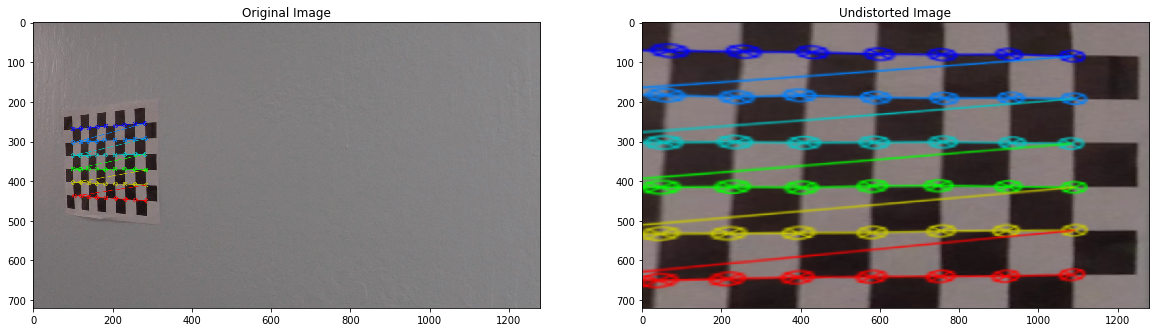

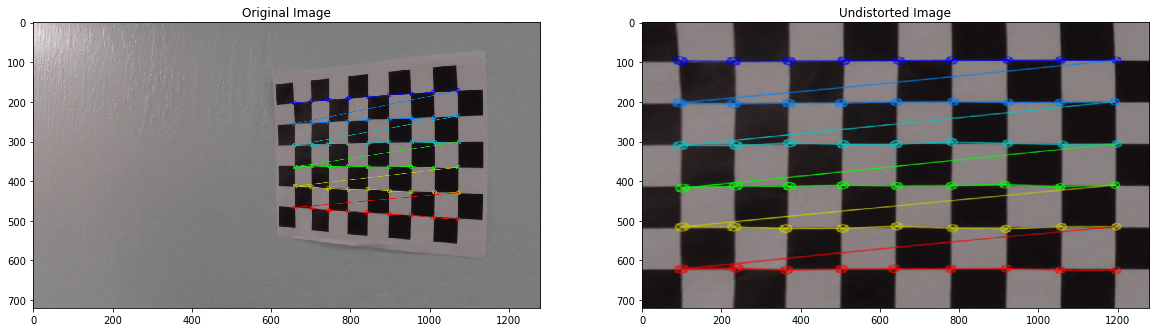

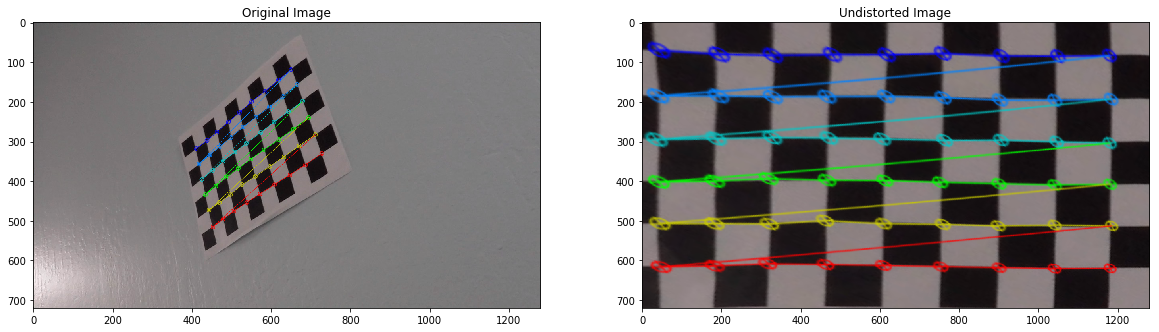

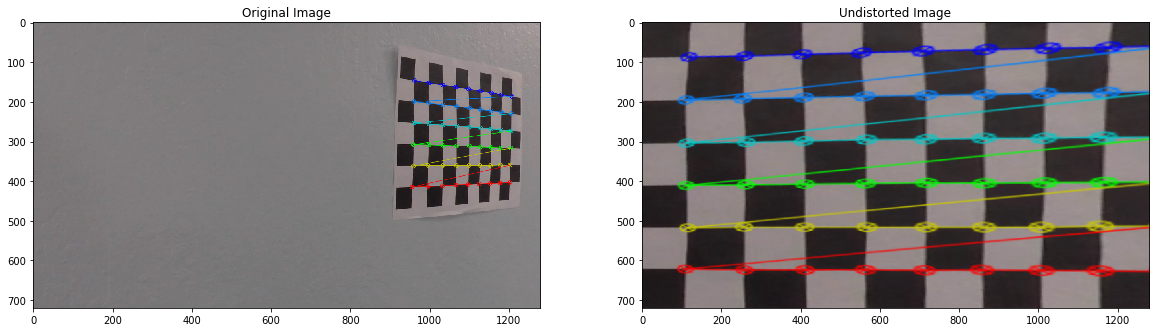

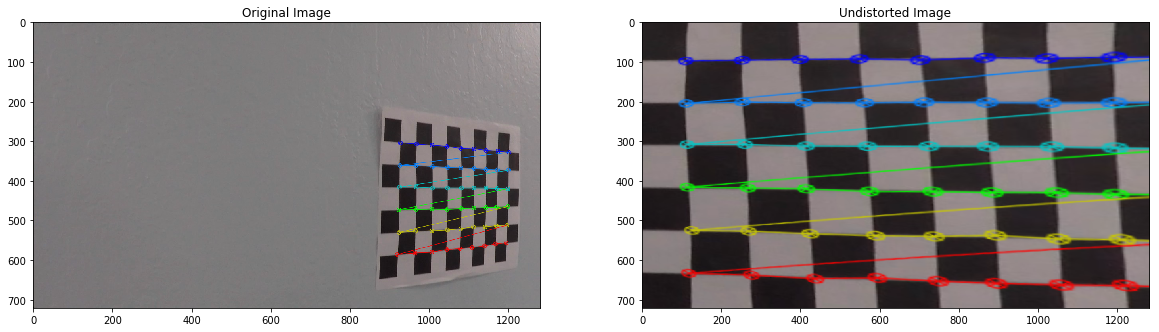

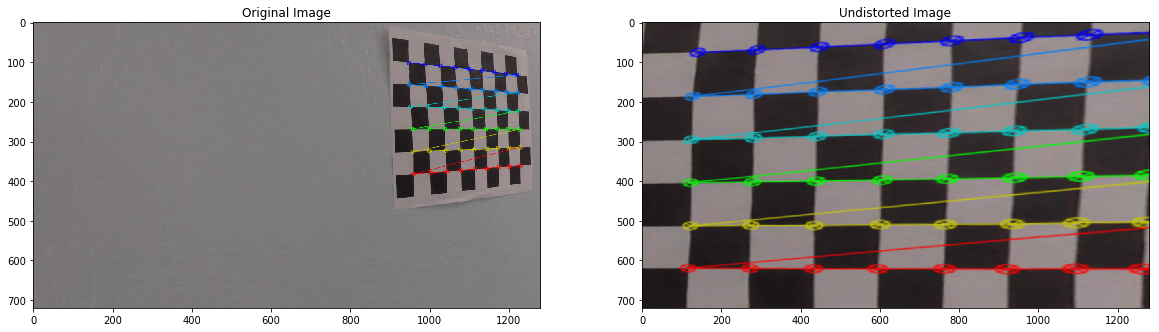

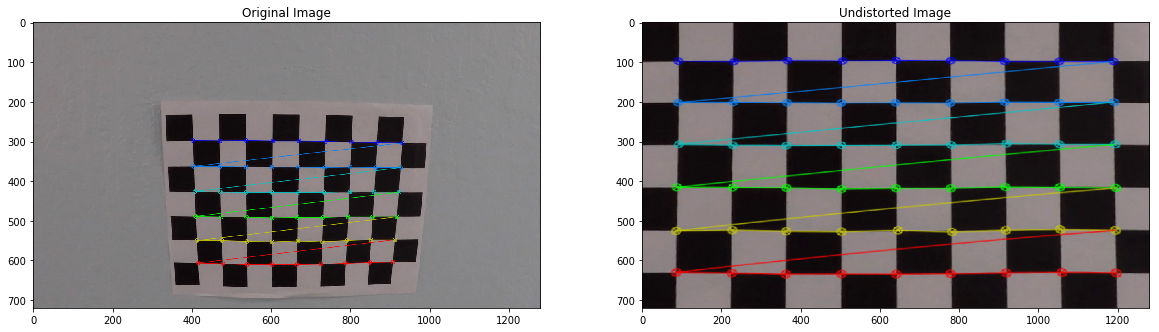

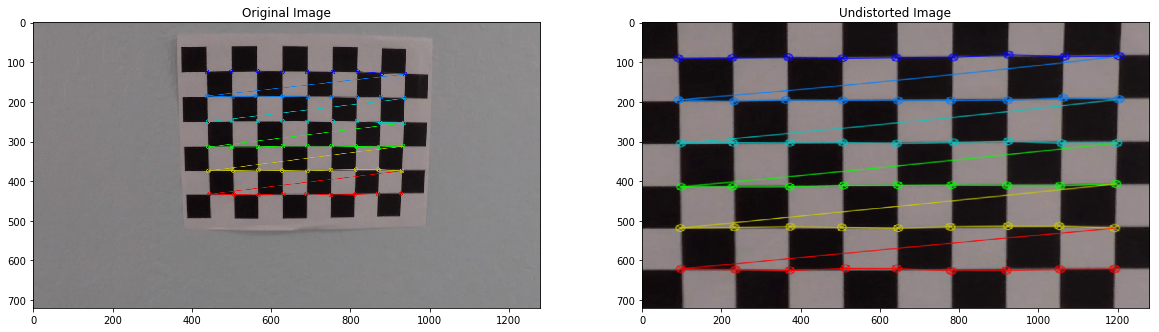

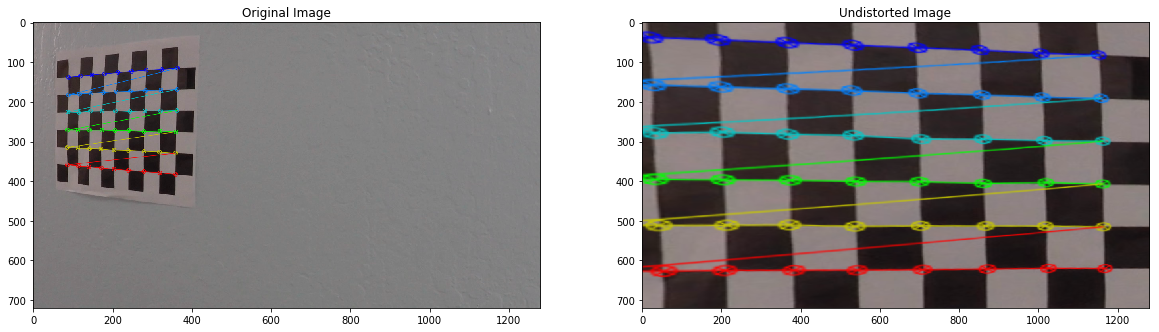

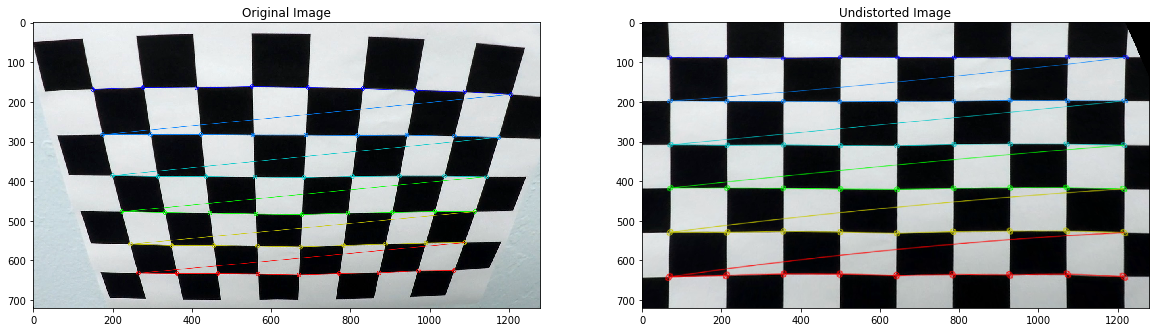

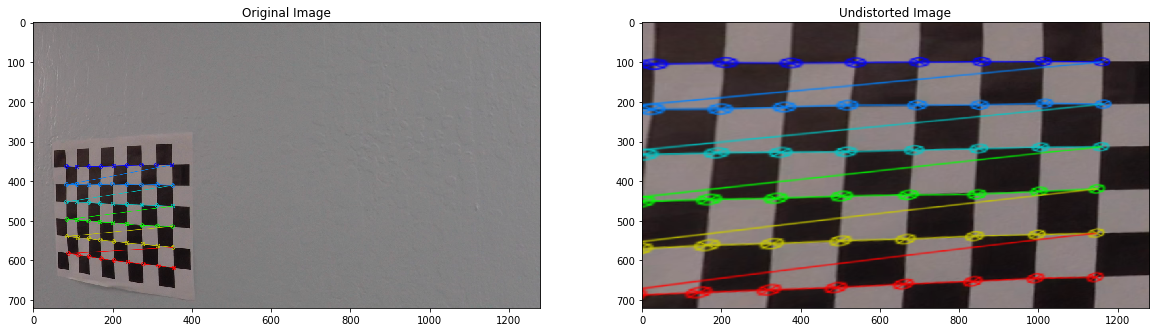

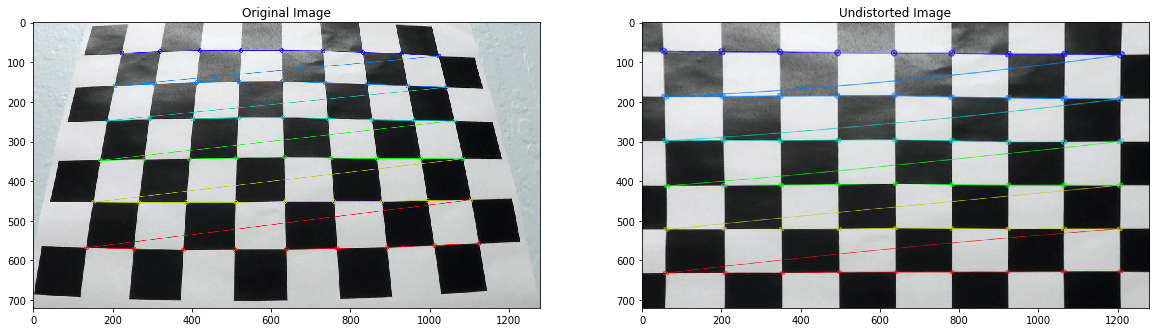

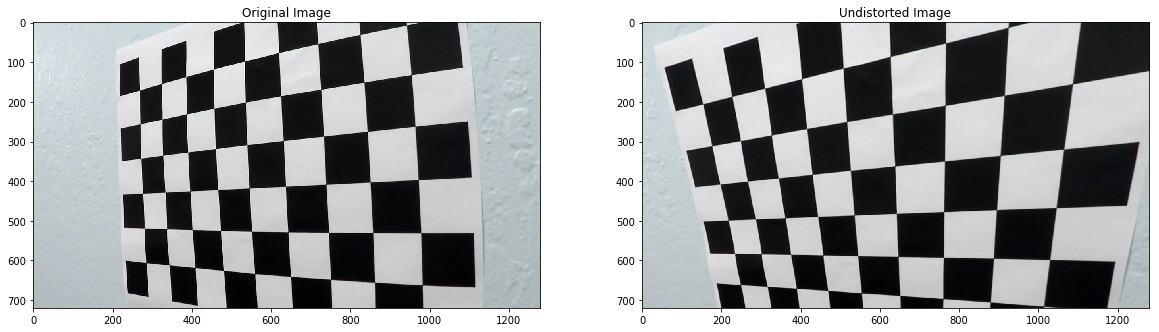

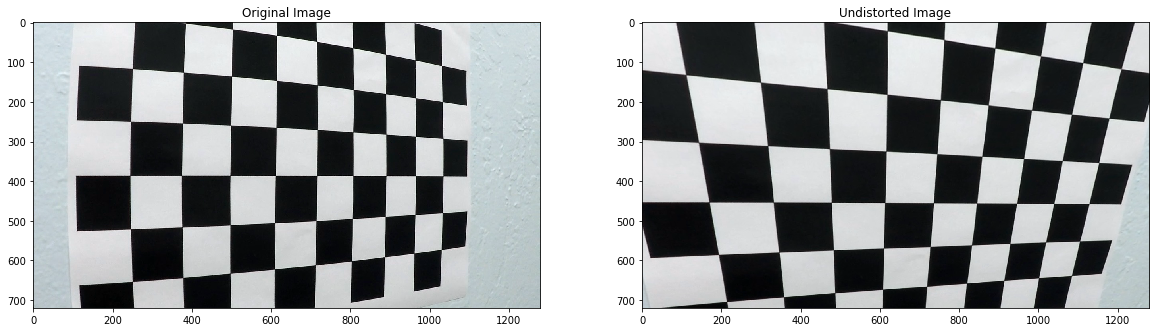

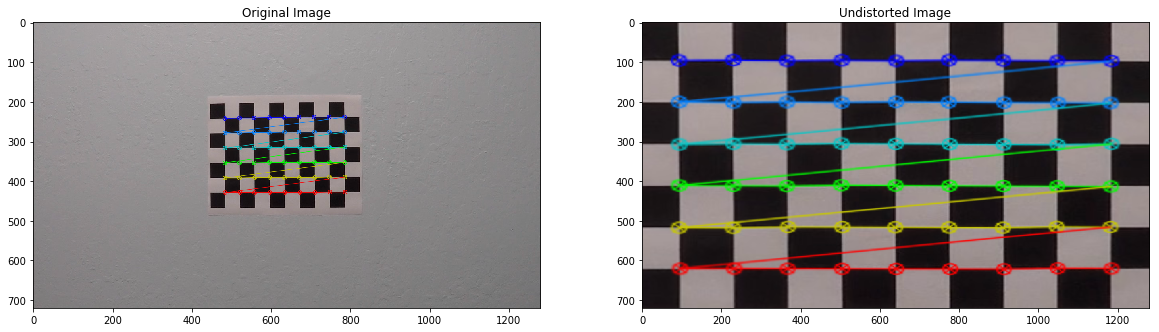

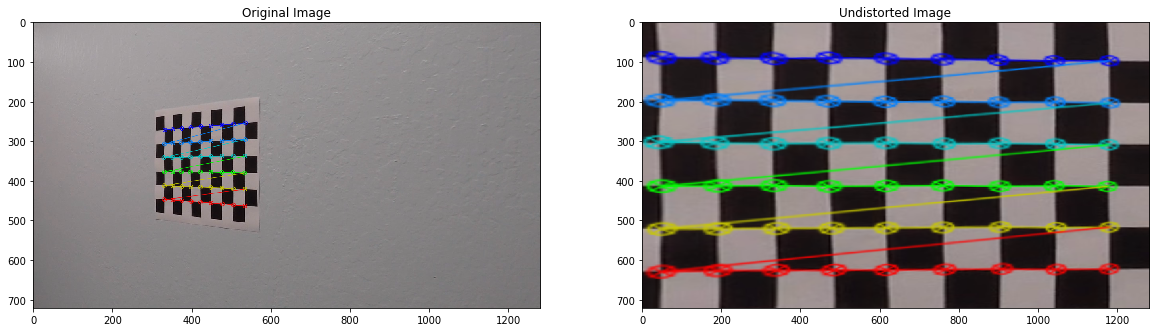

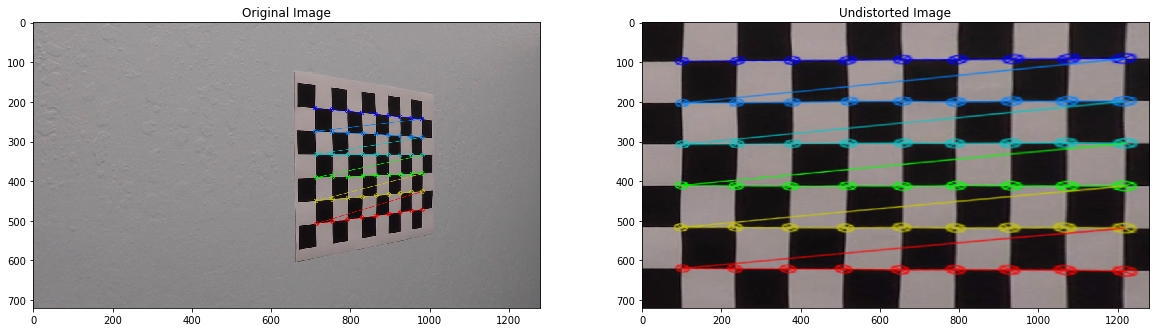

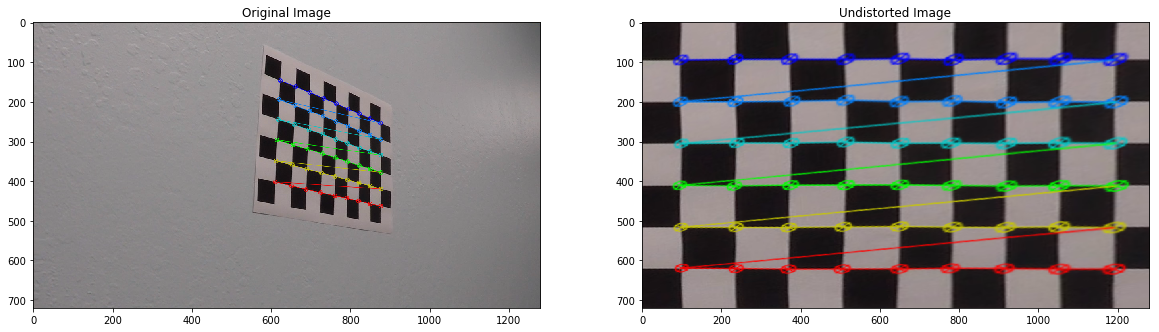

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# We create arrays to store our object points and image points from all the availadble images.
# 3d points in real world space
objpoints = [] 
# 2d points in image plane.
imgpoints = [] 

nx = 9
ny = 6

# Now we make a list of al the availadble calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

print('Total of calibration images: ', len(images))

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        
        offset = 100 # offset for dst points
        
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
        M = cv2.getPerspectiveTransform(src, dst)
        
    if objpoints and imgpoints:
        undistwarped_img, mtx, cal_dist = cal_undistort(img, objpoints, imgpoints)
        warped = cv2.warpPerspective(undistwarped_img, M, img_size)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image')
        ax2.imshow(warped)
        ax2.set_title('Undistorted Image')

## Apply a distortion correction to raw images

In [4]:
test_images = glob.glob('../test_images/*.jpg')
dist_images = []

for image in test_images:
    # Read image and transform to RGB first
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_shape = img.shape
    height = im_shape[0]
    width = im_shape[1]
    
    src_points = [(290, 660), (1020, 660), (595, 450), (690, 450)]
    dst_points = [(200, 720), (1080, 720), (200, -500), (1080, -500)]

    warped_image, M, M_inv = warp(img, src_points, dst_points)
    dist_images.append(warped_image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax2.imshow(warped_image)
    ax2.set_title('Undistorted Image')

NameError: name 'warp' is not defined

## Apply a perspective transform to rectify binary image ("birds-eye view").

## Use color transforms, gradients, etc., to create a thresholded binary image

In [ ]:
def color_mask(hsv,low,high):
    # Return mask from HSV 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv, img, low, high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img, img, mask=mask)
    return(res)

In [ ]:
# Yellow lane lines

image_hsv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)

yellow_hsv_low  = np.array([ 0,  100,  100])
yellow_hsv_high = np.array([ 80, 255, 255])


res_mask = color_mask(image_hsv, yellow_hsv_low, yellow_hsv_high)

res = apply_color_mask(image_hsv, warped_image, yellow_hsv_low, yellow_hsv_high)

plt.subplot(1,3,1)
plt.imshow(warped_image)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(res)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(res_mask)
plt.axis('off');

In [ ]:
# White lane lines

image_HSV = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)


hsv  = np.array([ 0,   0,   250])
white_hsv_high = np.array([ 255,  80, 255])

#white_hsv_low  = np.array([  0,   0,    80])
#white_hsv_high = np.array([ 255,  255, 255])

res1 = apply_color_mask(image_hsv, warped_image, white_hsv_low, white_hsv_high)

plt.subplot(1,2,1)
plt.imshow(warped_image)
plt.title('bird-eye view')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res1)
plt.title('bird-eye view')
plt.axis('off');

In [ ]:
# Combine Y and W

mask_yellow = color_mask(image_hsv, yellow_hsv_low, yellow_hsv_high)
mask_white = color_mask(image_hsv, white_hsv_low, white_hsv_high)
mask_lane = cv2.bitwise_or(mask_yellow, mask_white)
plt.imshow(mask_lane,cmap='gray')
plt.title('combined lane mask')
plt.axis('off');

In [ ]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient=='x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img,cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = 0*sobel
    binary_output[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

In [ ]:
def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

In [ ]:
image = gaussian_blur(warped_image, kernel=5)
image_hls = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HLS)


In [ ]:
plt.subplot(1,3,1)
plt.imshow(image_hsv[:,:,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(image_hsv[:,:,1],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image_hsv[:,:,2],cmap='gray')

In [ ]:

kernel_size = 9

# for image in dist_images:
image = gaussian_blur(warped_image, kernel=kernel_size)
plt.imshow(image)
image_hls = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HLS)

img_gs = image_hls[:, :, 1]
#img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
# sobel_c = sobel_combined(img_gs)
#img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
#img_m_mag = mag_thresh(img_gs,5,(20,265))
img_abs_x = abs_sobel_thresh(img_gs,'x', 5, (50,225))
img_abs_y = abs_sobel_thresh(img_gs,'y', 5, (50,225))
wraped3 = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))

# plt.imshow(cv2.bitwise_or(img_abs_x, img_abs_y),cmap='gray')
# plt.imshow(img_gs)

# gradx = abs_sobel_thresh(image_l, orient='x', sobel_kernel=ksize, thresh=(50, 225))
# grady = abs_sobel_thresh(image_l, orient='y', sobel_kernel=ksize, thresh=(50, 225))

# mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(5, 200))
# dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(10, np.pi/2))

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,10))

ax1.imshow(warped_image)
ax1.set_title('Original Image', fontsize=10)

ax2.imshow(img_abs_x, cmap='gray')
ax2.set_title('Sobel X Transformation', fontsize=10)

ax3.imshow(img_abs_y, cmap='gray')
ax3.set_title('Sobel Y Transformation', fontsize=10)

ax4.imshow(mag_binary, cmap='gray')
ax4.set_title('Magnitude threshold Transformation', fontsize=10)

ax5.imshow(dir_binary, cmap='gray')
ax5.set_title('Direction threshold Transformation', fontsize=10)

In [ ]:
# image_cmb = cv2.bitwise_or(wraped2, wraped3)
image_cmb = wraped3
#image_cmb = cv2.bitwise_or(image_cmb,res)
#image_cmb = gaussian_blur(image_cmb,3)

image_cmb1 = np.zeros_like(image_cmb)
image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1


plt.subplot(1,3,1)
plt.imshow(image_cmb,cmap='gray')
plt.axis('off')
plt.title('Sobel-filter')
plt.subplot(1,3,2)
plt.imshow(mask_lane,cmap='gray')
plt.axis('off')
plt.title('Color-mask')
plt.subplot(1,3,3)
plt.imshow(image_cmb1,cmap='gray')
plt.axis('off')
plt.title('Comb')

## Detect lane pixels and fit to find the lane boundary.

In [ ]:
def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
plt.imshow(gaussian_blur(image_cmb1,1),cmap='gray')
plt.axis('off')

In [ ]:
img_size = np.shape(image)

#image_cmb1 = gaussian_blur(image_cmb1,5) 
mov_filtsize = img_size[1]/50.
mean_lane = np.mean(image_cmb1[img_size[0]/2.:,:],axis=0)
mean_lane = moving_average(mean_lane,mov_filtsize)

print(img_size)

plt.subplot(2,1,1)
plt.imshow(image_cmb1[img_size[0]/2:,:],cmap='gray')
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')
plt.xlim(0,img_size[1])

In [ ]:
from scipy.signal import find_peaks_cwt
window_size=50


# Get peaks
indexes = find_peaks_cwt(mean_lane,[100], max_distances=[800])
window_size=50
val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
ind_sorted = np.argsort(-val_ind)

ind_peakR = indexes[ind_sorted[0]]
ind_peakL = indexes[ind_sorted[1]]
if ind_peakR<ind_peakL:
    ind_temp = ind_peakR
    ind_peakR = ind_peakL
    ind_peakL = ind_temp

n_vals = 8

# Get windows for bottom frame
ind_min_L = ind_peakL-50
ind_max_L = ind_peakL+50

ind_min_R = ind_peakR-50
ind_max_R = ind_peakR+50

mask_L_poly = np.zeros_like(image_cmb1)
mask_R_poly = np.zeros_like(image_cmb1)
print(ind_peakL,ind_peakR)
ind_peakR_prev = ind_peakR
ind_peakL_prev = ind_peakL

plt.figure(figsize=(10,6))

steps = 10

# Slide window up for each 1/8th of image
for i in range(steps):
    img_y1 = img_size[0]-img_size[0]*i/steps
    img_y2 = img_size[0]-img_size[0]*(i+1)/steps
    
    mean_lane_y = np.mean(image_cmb1[img_y2:img_y1,:],axis=0)
    mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
    indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
    
    
    # If 2 peaks are detected assign peaks to correct side.
        
    if len(indexes)>1.5:
        val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
        ind_sorted = np.argsort(-val_ind)

        ind_peakR = indexes[ind_sorted[0]]
        ind_peakL = indexes[ind_sorted[1]]
        if ind_peakR<ind_peakL:
            ind_temp = ind_peakR
            ind_peakR = ind_peakL
            ind_peakL = ind_temp
            
    else:
        # If 1 peak is detected, assign peak to closest peak in previous 1/8th image.
        if len(indexes)==1:
            if np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev):
                ind_peakR = indexes[0]
                ind_peakL = ind_peakL_prev
            else:
                ind_peakL = indexes[0]
                ind_peakR = ind_peakR_prev
        else:
            ind_peakL = ind_peakL_prev
            ind_peakR = ind_peakR_prev
            
                
    if np.abs(ind_peakL-ind_peakL_prev)>=100:
        ind_peakL = ind_peakL_prev
    if np.abs(ind_peakR-ind_peakR_prev)>=100:
        ind_peakR = ind_peakR_prev
    
            
    mask_L_poly[img_y2:img_y1,ind_peakL-window_size:ind_peakL+window_size] = 1.     
    mask_R_poly[img_y2:img_y1,ind_peakR-window_size:ind_peakR+window_size] = 1. 
   
    ind_peakL_prev = ind_peakL
    ind_peakR_prev = ind_peakR
    
    
    

    plt.subplot(steps,3,31-3*i-2)
    #plt.imshow(image_cmb1[img_y2:img_y1,:],cmap='gray')
    plt.plot(mean_lane_y)
    if i==steps-1:
        plt.title('Histogram')
    #plt.plot(right_pt,pt_y-img_y2,'rs')
    plt.axis('off')  
    plt.subplot(steps, 3, 31-3*i-3)
    plt.imshow(image_cmb1[img_y2:img_y1,:],cmap='gray')
    #plt.plot(mean_lane_y)
    #plt.plot(right_pt,pt_y-img_y2,'rs')
    if i==steps-1:
        plt.title('Road section')
    plt.axis('off') 
    plt.subplot(steps,3,31-3*i-1)
    plt.imshow(mask_L_poly[img_y2:img_y1,:]+mask_R_poly[img_y2:img_y1,:])
    plt.axis('off')
    if i==steps-1:
        plt.title('Computed mask')

In [ ]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(mask_L_poly)
right_lane_inds = np.concatenate(mask_R_poly)

print(right_lane_inds.shape)


plt.imshow(mask_L_poly)
(thresh, im_bw) = cv2.threshold(mask_L_poly, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(im_bw)


In [ ]:

mask_L = mask_L_poly

img_L = np.copy(image_cmb1)
img_L = cv2.bitwise_and(img_L,img_L,mask=mask_L_poly)


mask_R = mask_R_poly

img_R = np.copy(image_cmb1)
img_R = cv2.bitwise_and(img_R, img_R, mask=mask_R_poly)
#img_L = gaussian_blur(img_L,5)
plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.axis('off')
plt.title('Left lane markings')
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.axis('off')
plt.title('Right lane markings');

In [ ]:
vals = np.argwhere(img_L>.5)
all_x = vals.T[0]
all_y =vals.T[1]

left_fit = np.polyfit(all_x, all_y, 2)
left_y = np.arange(11)*img_size[0]/10
left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]



# Plot up the fake data
plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.plot( left_fitx,left_y,'red',linewidth=2)
plt.axis('off');

vals = np.argwhere(img_R>.5)

all_x = vals.T[0]
all_y =vals.T[1]

right_fit = np.polyfit(all_x, all_y, 2)
right_y = np.arange(11)*img_size[0]/10
right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]



# Plot up the fake data
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.plot( right_fitx,right_y,'r',linewidth=2)
plt.axis('off');

In [ ]:
def get_mask_poly(img,poly_fit,window_sz):
    mask_poly = np.zeros_like(img)
    img_size = np.shape(img)

    poly_pts = []
    pt_y_all = []

    for i in range(8):
        img_y1 = img_size[0]-img_size[0]*i/8
        img_y2 = img_size[0]-img_size[0]*(i+1)/8

        pt_y = (img_y1+img_y2)/2
        pt_y_all.append(pt_y)
        poly_pt = np.round(poly_fit[0]*pt_y**2 + poly_fit[1]*pt_y + poly_fit[2])
    
        poly_pts.append(poly_pt)
    
        mask_poly[img_y2:img_y1,poly_pt-window_sz:poly_pt+window_sz] = 1.     

    return mask_poly, np.array(poly_pts),np.array(pt_y_all)

In [ ]:
window_sz = 20
mask_L_poly = np.zeros_like(image_cmb1)
mask_R_poly = np.zeros_like(image_cmb1)

left_pts = []
right_pts = []

pt_y_all = []

for i in range(8):
    img_y1 = img_size[0]-img_size[0]*i/8
    img_y2 = img_size[0]-img_size[0]*(i+1)/8
    

    pt_y = (img_y1+img_y2)/2
    pt_y_all.append(pt_y)
    left_pt = np.round(left_fit[0]*pt_y**2 + left_fit[1]*pt_y + left_fit[2])
    right_pt = np.round(right_fit[0]*pt_y**2 + right_fit[1]*pt_y + right_fit[2])
    
    right_pts.append(right_fit[0]*pt_y**2 + right_fit[1]*pt_y + right_fit[2])
    left_pts.append(left_fit[0]*pt_y**2 + left_fit[1]*pt_y + left_fit[2])
    
    mask_L_poly[img_y2:img_y1,left_pt-window_sz:left_pt+window_sz] = 1.     
    mask_R_poly[img_y2:img_y1,right_pt-window_sz:right_pt+window_sz] = 1.     

    plt.subplot(8,1,8-i)
    plt.imshow(image_cmb1[img_y2:img_y1,:],cmap='gray')
    plt.plot(left_pt,pt_y-img_y2,'gs')
    plt.plot(right_pt,pt_y-img_y2,'rs')
    plt.axis('off')

In [ ]:
def draw_pw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)

warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
pts = np.hstack((pts_left, pts_right))


cv2.fillPoly(color_warp, np.int_([pts]), (102,104, 255))

col_L = (255,0,0)
col_R = (255,255,255)    

draw_pw_lines(color_warp,np.int_(pts_left),col_L)
draw_pw_lines(color_warp,np.int_(pts_right),col_L)


newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 


result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)

In [ ]:
plt.imshow(img)

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(color_warp)
plt.axis('off')
plt.title('Color warp')
plt.subplot(1,3,2)
plt.imshow(newwarp)
plt.title('Transformed color warp')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(result)
plt.title('Color warp on original image')
plt.axis('off')

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
mtx
dist_camera = cal_dist

def get_initial_mask(img,window_sz):
    
    # This function gets the initial mask
    
    img = gaussian_blur(img,5)
    img_size = np.shape(img)
    mov_filtsize = img_size[1]/50.
    mean_ln = np.mean(img[img_size[0]/2:,:],axis=0)
    mean_ln = moving_average(mean_ln,mov_filtsize)
    
    indexes = find_peaks_cwt(mean_ln,[100], max_distances=[800])

    val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    if ind_peakR<ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp

    n_vals = 8
    ind_min_L = ind_peakL-window_sz
    ind_max_L = ind_peakL+window_sz

    ind_min_R = ind_peakR-window_sz
    ind_max_R = ind_peakR+window_sz

    mask_L_i = np.zeros_like(img)
    mask_R_i = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    # Split image into 8 parts and compute histogram on each part
    
    for i in range(8):
        img_y1 = img_size[0]-img_size[0]*i/8
        img_y2 = img_size[0]-img_size[0]*(i+1)/8
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(indexes)>1.5:
            val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp
            
        else:
        # If no pixels are found, use previous ones. 
            if len(indexes)==1:
                if (np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev)):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev
            else:
                ind_peakL = ind_peakL_prev
                ind_peakR = ind_peakR_prev
            
            
        # If new center is more than 60pixels away, use previous
        # Outlier rejection
        if np.abs(ind_peakL-ind_peakL_prev)>=60:
            ind_peakL = ind_peakL_prev

        if np.abs(ind_peakR-ind_peakR_prev)>=60:
            ind_peakR = ind_peakR_prev
            
    
            
        mask_L_i[img_y2:img_y1,ind_peakL-window_sz:ind_peakL+window_sz] = 1.
        mask_R_i[img_y2:img_y1,ind_peakR-window_sz:ind_peakR+window_sz] = 1.
        
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
    return mask_L_i,mask_R_i



def get_mask_poly(img,poly_fit,window_sz):
    
    # This function returns masks for points used in computing polynomial fit. 
    mask_poly = np.zeros_like(img)
    img_size = np.shape(img)

    poly_pts = []
    pt_y_all = []

    for i in range(8):
        img_y1 = img_size[0]-img_size[0]*i/8
        img_y2 = img_size[0]-img_size[0]*(i+1)/8

        pt_y = (img_y1+img_y2)/2
        pt_y_all.append(pt_y)
        poly_pt = np.round(poly_fit[0]*pt_y**2 + poly_fit[1]*pt_y + poly_fit[2])
    
        poly_pts.append(poly_pt)
    
        mask_poly[img_y2:img_y1,poly_pt-window_sz:poly_pt+window_sz] = 1.     

    return mask_poly, np.array(poly_pts),np.array(pt_y_all)
    

def get_val(y,pol_a):
    # Returns value of a quadratic polynomial 
    return pol_a[0]*y**2+pol_a[1]*y+pol_a[2]

def draw_pw_lines(img,pts,color):
    # This function draws lines connecting 10 points along the polynomial
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)
        
def undistort_image(img, mtx, dist):
    # Function to undistort image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
def gaussian_blur(img, kernel=5):
    # Function to smooth image
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output
    
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    # Gaussian adaptive thresholding (NOT USED )
    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

def warp_image(img,src,dst,img_size):
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv

def sobel_combined(image):
    # Combine sobel masks.
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined


def color_mask(hsv,low,high):
    # Takes in low and high values and returns mask
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Takes in color mask and returns image with mask applied.
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_curvature(pol_a,y_pt):
    # Returns curvature of a quadratic
    A = pol_a[0]
    B = pol_a[1]
    R_curve = (1+(2*A*y_pt+B)**2)**1.5/2/A
    return R_curve

def stack_arr(arr):
    # Stacks 1-channel array into 3-channel array to allow plotting
    return np.stack((arr, arr,arr), axis=2)


def apply_perspective_transform(image):
    # Applies bird-eye perspective transform to an image
    img_size = image.shape
    ht_window = np.uint(img_size[0]/1.5)
    hb_window = np.uint(img_size[0])
    c_window = np.uint(img_size[1]/2)
    ctl_window = c_window - .25*np.uint(img_size[1]/2)
    ctr_window = c_window + .25*np.uint(img_size[1]/2)
    cbl_window = c_window - 1*np.uint(img_size[1]/2)
    cbr_window = c_window + 1*np.uint(img_size[1]/2)
    src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],
                      [ctr_window,ht_window],[ctl_window,ht_window]])
    dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])
    
    warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0])) # returns birds eye image
    return warped,M_warp,Minv_warp

In [ ]:
def pipeline_process_highway(image):
    
    global left_fit_prev   
    global right_fit_prev
    global col_R_prev
    global col_L_prev
    global set_prev
    global mask_poly_L
    global mask_poly_R
    

    # Undistort image

    image = undistort_image(image, mtx, cal_dist)
    image = gaussian_blur(image, kernel=5)
    img_size = np.shape(image)
    
    # Define window for perspective transform
    warped,M_warp,Minv_warp = apply_perspective_transform(image)
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

    # Define color ranges and apply color mask
    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])
    # get yellow and white masks 
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    # Combine white and yellow masks into 1
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white) 
    
    # Convert image to HLS scheme
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

    # Apply sobel filters on L and S channels.
    img_gs = image_HLS[:,:,1]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
    wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
    wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    

    # Combine sobel filter information from L and S channels.
    image_cmb = cv2.bitwise_or(wraped2,wraped3)
    image_cmb = gaussian_blur(image_cmb,25)
    

    # Combine masks from sobel and color masks.

    image_cmb1 = np.zeros_like(image_cmb)
    image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1
    
    
    # If this is first frame, get new mask.
    if set_prev == 0:
        image_cmb1 = gaussian_blur(image_cmb1,5)
        mask_poly_L,mask_poly_R = get_initial_mask(image_cmb1,40)

        
        
    # Define all colors as white to start.         
    col_R = (255,255,255)
    col_L = (255,255,255)
    col_R = (255,255,255)
    col_L = (255,255,255)
    
    # Apply mask to sobel images and compute polynomial fit for left. 
    img_L = np.copy(image_cmb1)
    img_L = cv2.bitwise_and(image_cmb1,image_cmb1,
                                mask = mask_poly_L)
    vals = np.argwhere(img_L>.5)
    if len(vals)<5: ## If less than 5 points 
        left_fit = left_fit_prev
        col_L = col_L_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        left_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(img_L,mask_yellow))>1000:
            col_L = (255,255,0)
            
    # Apply mask to sobel images and compute polynomial fit for right. 

    img_R = np.copy(image_cmb1)
    img_R = cv2.bitwise_and(image_cmb1,image_cmb1,
                                mask = mask_poly_R)
    vals = np.argwhere(img_R>.5)
        
    if len(vals)<5:
        right_fit = right_fit_prev
        col_R = col_R_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        right_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(img_R,mask_yellow))>1000:
            col_R = (255,255,0)
    
    
    ## assign initial mask, and save coefficient values for next frame
            
    if set_prev == 0:
        set_prev = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit
    
       
    ## Check error between current coefficient and on from previous frame
    err_p_R = np.sum((right_fit[0]-right_fit_prev[0])**2) #/np.sum(right_fit_prev[0]**2)
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>.0005:
        right_fit = right_fit_prev
        col_R = col_R_prev
    else:
        right_fit = .05*right_fit+.95*right_fit_prev
        
    ## Check error between current coefficient and on from previous frame
    err_p_L = np.sum((left_fit[0]-left_fit_prev[0])**2) #/np.sum(right_fit_prev[0]**2)
    err_p_L = np.sqrt(err_p_L)
    if err_p_L>.0005:
        left_fit =  left_fit_prev
        col_L = col_L_prev
    else:
        left_fit =  .05* left_fit+.95* left_fit_prev
    

    ## Compute lane mask for future frame 
    mask_poly_L,left_pts,img_pts = get_mask_poly(image_cmb1,left_fit,window_size)
    mask_poly_R,right_pts,img_pts = get_mask_poly(image_cmb1,right_fit,window_size)
     
        
    ## Compute lanes
        
    right_y = np.arange(11)*img_size[0]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    left_y = np.arange(11)*img_size[0]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))
    

    ## Compute intercepts
    left_bot = get_val(img_size[0],left_fit)
    right_bot = get_val(img_size[0],right_fit)
    
    ## Compute center location
    val_center = (left_bot+right_bot)/2.0
    
    ## Compute lane offset
    dist_offset = val_center - img_size[1]/2
    dist_offset = np.round(dist_offset/2.81362,2)
    str_offset = 'Lane deviation: ' + str(dist_offset) + ' cm.'
    
    if dist_offset>30:
        cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
    else:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))
        

    # Draw the lane onto the warped blank image    
    draw_pw_lines(color_warp,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp,np.int_(pts_right),col_R)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    
    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    left_curve = get_curvature(left_fit,img_size[0]/2)
    Right_curve = get_curvature(right_fit,img_size[0]/2)
    
    str_curv = 'Curvature: Right = ' + str(np.round(Right_curve,2)) + ', Left = ' + str(np.round(left_curve,2)) 
    # Change color if distance is more than 30 cm
    font = cv2.FONT_HERSHEY_COMPLEX    
    if dist_offset<30:
        cv2.putText(result, str_curv, (30, 60), font, 1, (0,255,0), 2)
        cv2.putText(result, str_offset, (30, 90), font, 1, (0,255,0), 2)
    else:
        cv2.putText(result, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(result, str_offset, (30, 90), font, 1, (255,0,0), 2)
    
    
    
    right_fit_prev = right_fit
    left_fit_prev  = left_fit
    col_R_prev = col_R
    col_L_prev = col_L
    
    
    #return result    # using cv2 for drawing text in diagnostic pipeline.
    
    if do_diagnosis == 1:
        font = cv2.FONT_HERSHEY_COMPLEX
        middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
        cv2.putText(middlepanel, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(middlepanel, str_offset, (30, 90), font, 1, (255,0,0), 2)
    
        # assemble the screen example
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:720, 0:1280] = result
        diagScreen[0:240, 1280:1600] = cv2.resize(warped, (320,240), interpolation=cv2.INTER_AREA) 
        diagScreen[0:240, 1600:1920] = cv2.resize(stack_arr(mask_lane), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1280:1600] = cv2.resize(apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1600:1920] = cv2.resize(apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high), (320,240), interpolation=cv2.INTER_AREA)*4
        diagScreen[600:1080, 1280:1920] = cv2.resize(color_warp, (640,480), interpolation=cv2.INTER_AREA)*4
        diagScreen[720:840, 0:1280] = middlepanel
        diagScreen[840:1080, 0:320] = cv2.resize(newwarp, (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*mask_poly_L), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*mask_poly_R), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
    
        diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*mask_poly_L+255*mask_poly_R), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*cv2.bitwise_and(image_cmb1,image_cmb1,
                                                                              mask=mask_poly_L+mask_poly_R)),
                                                (320,240), interpolation=cv2.INTER_AREA)
        return diagScreen
    else:
        return result

In [ ]:
set_prev = 0
do_diagnosis = 0

project_output = '../output/project_video_output.mp4'
clip1 = VideoFileClip("../project_video.mp4");
white_clip = clip1.fl_image(pipeline_process_highway) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);

In [ ]:
set_prev = 0
do_diagnosis = 0

project_output = '../output/challenge_video_output.mp4'
clip1 = VideoFileClip("../challenge_video.mp4");
white_clip = clip1.fl_image(pipeline_process_highway) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);

In [ ]:
set_prev = 0
do_diagnosis = 0

project_output = '../output/harder_challenge_video_output.mp4'
clip1 = VideoFileClip("../harder_challenge_video.mp4");
white_clip = clip1.fl_image(pipeline_process_highway) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);